# Run QNet on Lander

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import numpy as np
from tqdm.notebook import trange
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

sys.path.append('RL_lib/Agents/PPO')
sys.path.append('RL_lib/Utils')
sys.path.append('../')

import QLearn
import env_lib
from policy_ppo import Policy
from value_function import Value_function
from utils import Mapminmax,Logger,Scaler
import utils
from env_gaudet_lander import LanderEnvironment, int_to_bin, bin_to_int

Inertia Tensor:  [[2000.    0.    0.]
 [   0. 2000.    0.]
 [   0.    0. 3200.]]
Lander Model: 
 - apf_v0:  70
 - apf_vf1:  [ 0.  0. -2.]
 - apf_vf2:  [ 0.  0. -1.]
 - apf_atarg:  15.0
 - apf_tau1:  20
 - apf_tau2:  100.0
Attitude Constraint
Reward_terminal
lander env att 2 fixed
PPO Policy 1

Instructions for updating:
Use keras.layers.dense instead.

Policy Params -- h1: 120, h2: 69, h3: 40, lr: 0.000108, logvar_speed: 8


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Actions
[[0.]
 [1.]]
10
Actor Test Mode:  False
clip param:  0.1
dict_keys(['h1/bias:0', 'h1/kernel:0', 'h2/bias:0', 'h2/kernel:0', 'means/bias:0', 'h3/bias:0', 'means/kernel:0', 'logvars:0', 'h3/kernel:0'])


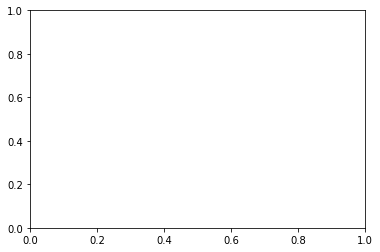

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

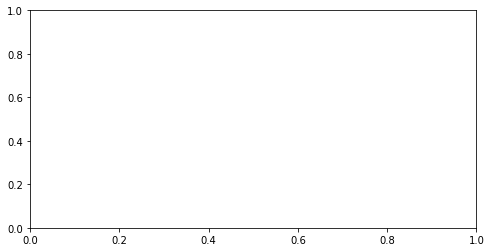

In [4]:
env = LanderEnvironment()
obs_dim = 12
act_dim = 4

policy = Policy(obs_dim,act_dim,kl_targ=0.001,epochs=20, beta=0.1, shuffle=True, servo_kl=True, discretize=True)

fname = "optimize_4km"
input_normalizer = utils.load_run(policy,fname)

## Baseline Performances

In [9]:
def ppo_policy(s):
    s_norm = input_normalizer.apply(s)
    a = policy.sample(s_norm.reshape(1,-1))
    return bin_to_int(list(a[1][0]))

def random_policy(s):
    return np.random.randint(16)

In [10]:
R_rand = QLearn.heuristic_demo(random_policy,env,100)

*** ATT VIO TYPE CNT:  [ 0. 40. 61.]


In [13]:
policy.test_mode=True
R_ppo = QLearn.heuristic_demo(ppo_policy,env,100)

100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


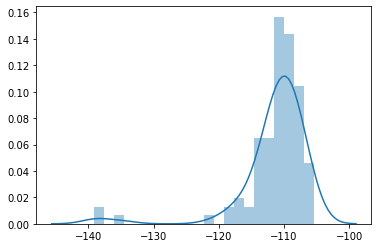

In [11]:
sns.distplot(R_rand)

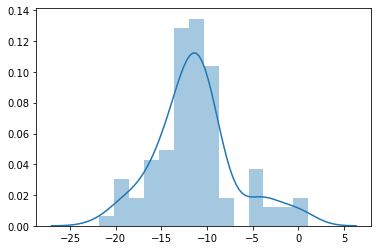

In [16]:
sns.distplot(R_ppo)

In [ ]:
N_ep = 2000
policy.test_mode=True
agent = QLearn.QAgent(env, net_type='QNet', f_heur=ppo_policy, n_heur=100,
                    update_steps=10, N_hid=100, eps0=0.9, gamma=0.99, n_eps=1500, memory_size=100000, minibatch_size=25)
R_ep, agent, env = do_run(agent, env, N_ep)

In [9]:
agent.nn.sess.close()

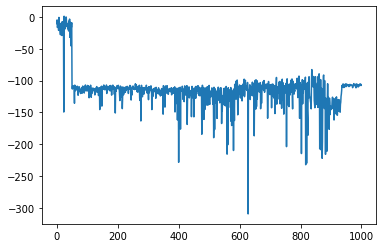

In [26]:
plt.plot(R_ep)

In [5]:
asdf = pickle.load(open('test_qlearn_11_3.pkl','rb'))

In [7]:
asdf.keys()

dict_keys(['params', 'R', 'step'])

In [11]:
r_avg = [np.mean(r) for r in asdf['R']]
r_max = [np.max(r) for r in asdf['R']]

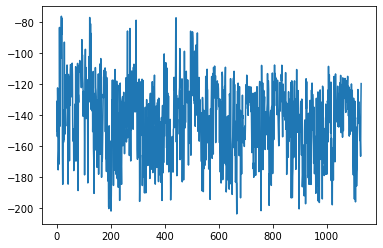

In [14]:
plt.plot(r_avg)